## Predict Daily Minimum Temperatures pipeline

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Concatenate, Activation, BatchNormalization, MaxPooling1D, Dropout, add, Bidirectional, Flatten, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

#AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

2023-06-27 15:13:13.615174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 15:13:13.926671: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 15:13:13.948794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-27 15:13:13.948807: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-06-27 15:13:15.945677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-27 15:13:15.946997: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-27 15:13:15.947037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (N3N0B600577910H): /proc/driver/nvidia/version does not exist


### Load and preprocessing the dataset 

In [3]:
filenames = sorted(glob.glob('Data/*'))
filenames[:5]

['Data/2000_2000_Jan_Mai.csv',
 'Data/2000_2000_Jun_Nov.csv',
 'Data/2000_2001_Dez_Mai.csv',
 'Data/2001_2001_Jun_Nov.csv',
 'Data/2001_2002_Dez_Mai.csv']

In [4]:
data_df = pd.DataFrame()
names=['Data','Hora (UTC)','Temp. Ins. (C)','Temp. Max. (C)','Temp. Min. (C)','Umi. Ins. (%)','Umi. Max. (%)','Umi. Min. (%)','Chuva (mm)']

for filename in filenames:
    try:
        df_aux = pd.read_csv(filename, usecols=names)
    except:
        df_aux = pd.read_csv(filename, usecols=names, sep=';')
        
    if(len(df_aux) == 0):
        data_df = df_aux
    else:
        data_df = pd.concat([data_df, df_aux])
    
    del df_aux
        
print(data_df.shape)
data_df.tail()

(205656, 9)


,Data,Hora (UTC),Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Chuva (mm)
3307,18/05/2023,1900,"32,2","32,4","30,5","57,0","67,0","57,0","0,0"
3308,18/05/2023,2000,"30,8","32,5","30,7","63,0","63,0","55,0","0,0"
3309,18/05/2023,2100,"29,2","30,9","29,2","74,0","74,0","63,0","0,0"
3310,18/05/2023,2200,"28,9","29,4","28,8","73,0","75,0","70,0","0,0"
3311,18/05/2023,2300,"28,2","29,0","28,2","82,0","82,0","73,0","0,0"


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205656 entries, 0 to 3311
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Data            205656 non-null  object
 1   Hora (UTC)      205656 non-null  int64 
 2   Temp. Ins. (C)  168174 non-null  object
 3   Temp. Max. (C)  167524 non-null  object
 4   Temp. Min. (C)  167523 non-null  object
 5   Umi. Ins. (%)   167907 non-null  object
 6   Umi. Max. (%)   167250 non-null  object
 7   Umi. Min. (%)   167247 non-null  object
 8   Chuva (mm)      168085 non-null  object
dtypes: int64(1), object(8)
memory usage: 15.7+ MB


### Preprocessing 

In [6]:
for col in data_df.columns[2:]:
    data_df[col] = data_df[col].astype(str).str.replace(',','.').astype(float)
data_df['Data']=pd.to_datetime(data_df['Data'])
data_df

/home/bruno.dutra/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13/01/2000' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/bruno.dutra/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14/01/2000' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/bruno.dutra/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '15/01/2000' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/bruno.dutra/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '16/01/2000' in DD/

,Data,Hora (UTC),Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Chuva (mm)
0,2000-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-01,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-01,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-01,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-01,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3307,2023-05-18,1900,32.2,32.4,30.5,57.0,67.0,57.0,0.0
3308,2023-05-18,2000,30.8,32.5,30.7,63.0,63.0,55.0,0.0
3309,2023-05-18,2100,29.2,30.9,29.2,74.0,74.0,63.0,0.0
3310,2023-05-18,2200,28.9,29.4,28.8,73.0,75.0,70.0,0.0


In [7]:
aux1=data_df.groupby(['Data'])['Temp. Ins. (C)','Umi. Ins. (%)','Chuva (mm)'].agg('mean')
aux2=data_df.groupby(['Data'])['Temp. Max. (C)','Umi. Max. (%)'].agg('max')
aux3=data_df.groupby(['Data'])['Temp. Min. (C)','Umi. Min. (%)'].agg('min')
data_df= pd.concat([aux1, aux2,aux3], axis=1).reset_index()
data_df

/tmp/ipykernel_198246/2876059681.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aux1=data_df.groupby(['Data'])['Temp. Ins. (C)','Umi. Ins. (%)','Chuva (mm)'].agg('mean')
/tmp/ipykernel_198246/2876059681.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aux2=data_df.groupby(['Data'])['Temp. Max. (C)','Umi. Max. (%)'].agg('max')
/tmp/ipykernel_198246/2876059681.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aux3=data_df.groupby(['Data'])['Temp. Min. (C)','Umi. Min. (%)'].agg('min')


,Data,Temp. Ins. (C),Umi. Ins. (%),Chuva (mm),Temp. Max. (C),Umi. Max. (%),Temp. Min. (C),Umi. Min. (%)
0,2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8534,2023-12-01,27.686957,76.478261,0.113043,32.7,92.0,24.2,56.0
8535,2023-12-02,25.912500,87.541667,1.800000,30.8,98.0,22.8,64.0
8536,2023-12-03,24.570833,95.291667,2.908333,25.9,97.0,22.9,91.0
8537,2023-12-04,28.950000,74.208333,0.000000,33.8,94.0,25.5,50.0


In [8]:
data_df.isna().sum() 

Data                 0
Temp. Ins. (C)    1183
Umi. Ins. (%)     1185
Chuva (mm)        1186
Temp. Max. (C)    1198
Umi. Max. (%)     1201
Temp. Min. (C)    1198
Umi. Min. (%)     1201
dtype: int64

/home/bruno.dutra/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='Data'>

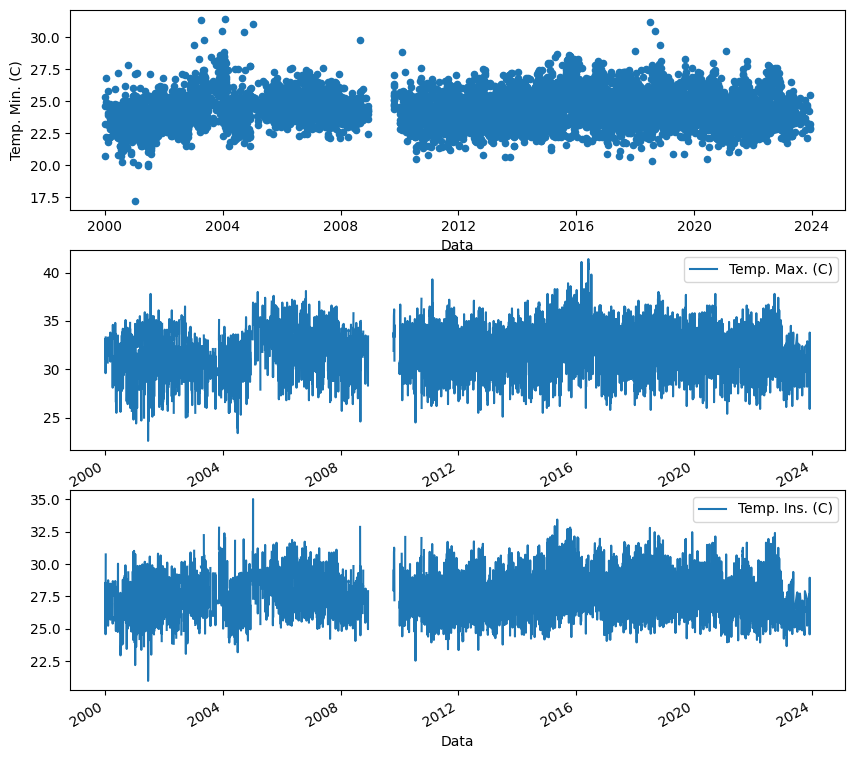

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))

data_df.plot.scatter(x='Data',y='Temp. Min. (C)', ax= axes[0])
data_df.plot(x='Data',y='Temp. Max. (C)', ax= axes[1])
data_df.plot(x='Data',y='Temp. Ins. (C)', ax= axes[2])

In [10]:
new_data=data_df.ffill()[data_df['Data']>'2010-01-02']
new_data=new_data.ffill()
#new_data=new_data.bfill()
#new_data=new_data.interpolate()


<AxesSubplot: xlabel='Data'>

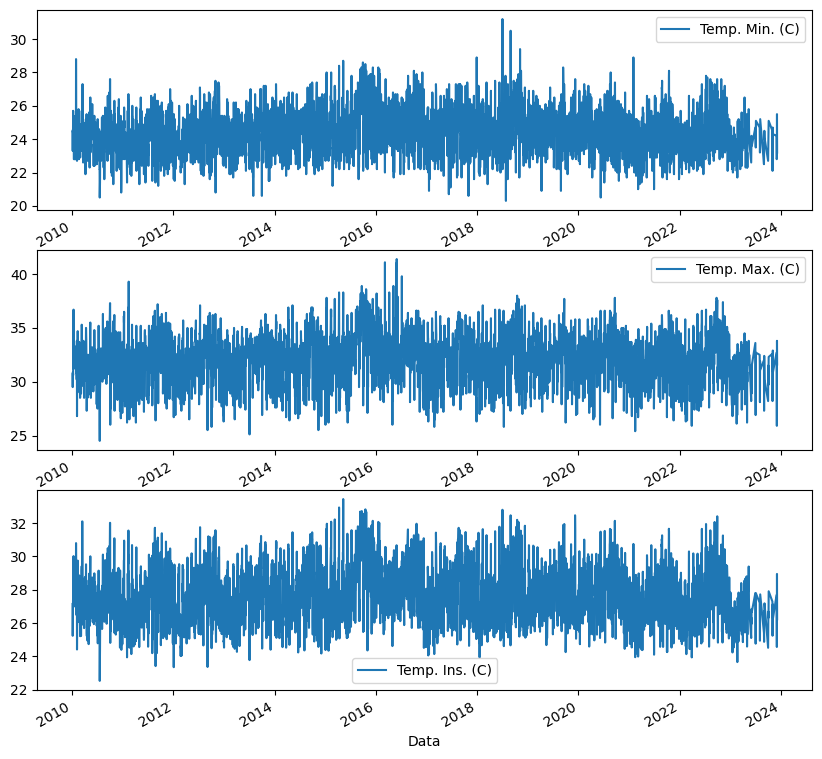

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))

new_data.plot(x='Data',y='Temp. Min. (C)', ax= axes[0])
new_data.plot(x='Data',y='Temp. Max. (C)', ax= axes[1])
new_data.plot(x='Data',y='Temp. Ins. (C)', ax= axes[2])


In [12]:
new_data['week']=new_data['Data'].dt.week
new_data['weekday']=new_data['Data'].dt.weekday+1
new_data['day']=new_data['Data'].dt.day
new_data['month']=new_data['Data'].dt.month
new_data['quarter']=new_data['Data'].dt.quarter

/tmp/ipykernel_198246/2780441076.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  new_data['week']=new_data['Data'].dt.week


In [13]:
columns=new_data.columns[new_data.isna().sum().values <100]

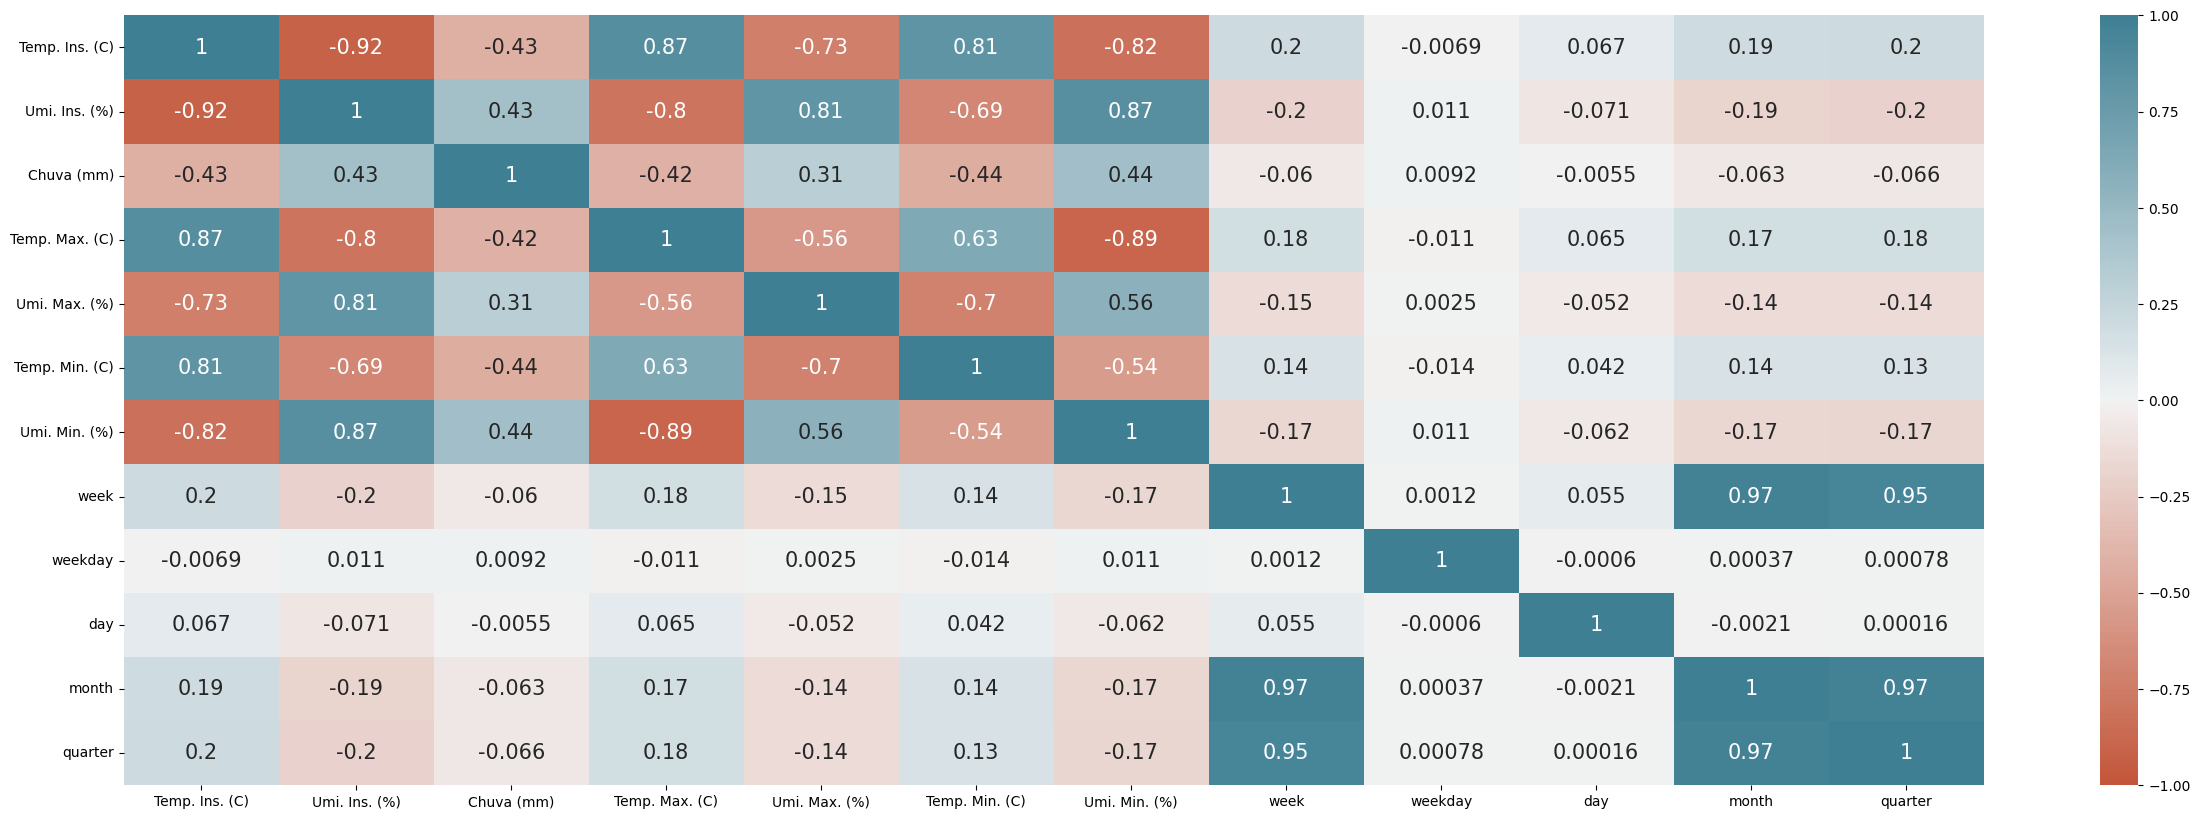

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(30,10))

corrmat = new_data[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [15]:
#sns.pairplot(data[columns])

### Init pipeline 

In [16]:
data= pd.DataFrame()
data['Date']=new_data['Data']
data['Temp max']=new_data['Temp. Max. (C)']
data['Temp min']=new_data['Temp. Min. (C)']

In [17]:
Steps_ahead=180
windows_size=180

### Processing the data


In [18]:
data = data.set_index('Date')

real_temp=data[-Steps_ahead:]
data=data[0:-Steps_ahead]

#### Splitting data into train and vall sets

In [19]:
idx_train_vall=(len(data)//3)
idx_train=range(0,len(data)-idx_train_vall)
idX_vall=range(len(data)-idx_train_vall,len(data))

In [20]:
#idx_train, idX_vall = train_vall_split(np.arange(len(data)), vall_size=0.2, shuffle=False)

#idx_train

#train= data['Temp'][idx_train].values.reshape(-1, 1)
#vall= data['Temp'][idX_vall].values.reshape(-1, 1)

train=data.reset_index().iloc[idx_train,:]
train_norm= train.copy()
vall=data.reset_index().iloc[idX_vall,:]
vall_norm= vall.copy()
# scale the data - normalization
scaler = MinMaxScaler()
train_norm[['Temp max','Temp min']] = scaler.fit_transform(train[['Temp max','Temp min']].values.reshape(-1, 2))
vall_norm[['Temp max','Temp min']] = scaler.transform(vall[['Temp max','Temp min']].values.reshape(-1, 2))

#pd.DataFrame(data).describe()

In [21]:
# Creating the input and output data for the neural network
def create_dataset(windows_size, data, Date=None):
    X, Y = [], []
    t_date =[]
    for i in range(len(data)-windows_size):
        X.append(data[i:i+windows_size])
        Y.append(data[i+windows_size])
        if [Date] != None:
            t_date+=[Date[i+windows_size]]
    if [Date] != None:
        return np.expand_dims(np.vstack(X),2).reshape(-1,windows_size,2), np.array(Y), np.array(t_date)
    else: 
        return np.expand_dims(np.vstack(X),2).reshape(-1,windows_size,2), np.array(Y)

X_train, Y_train, t_train = create_dataset(windows_size ,train_norm[['Temp max','Temp min']].values,train_norm['Date'].values)
X_vall, y_vall, t_vall = create_dataset(windows_size, vall_norm[['Temp max','Temp min']].values,vall_norm['Date'].values)

In [22]:
X_train.shape

(2956, 180, 2)

#### Plot the real temperature values

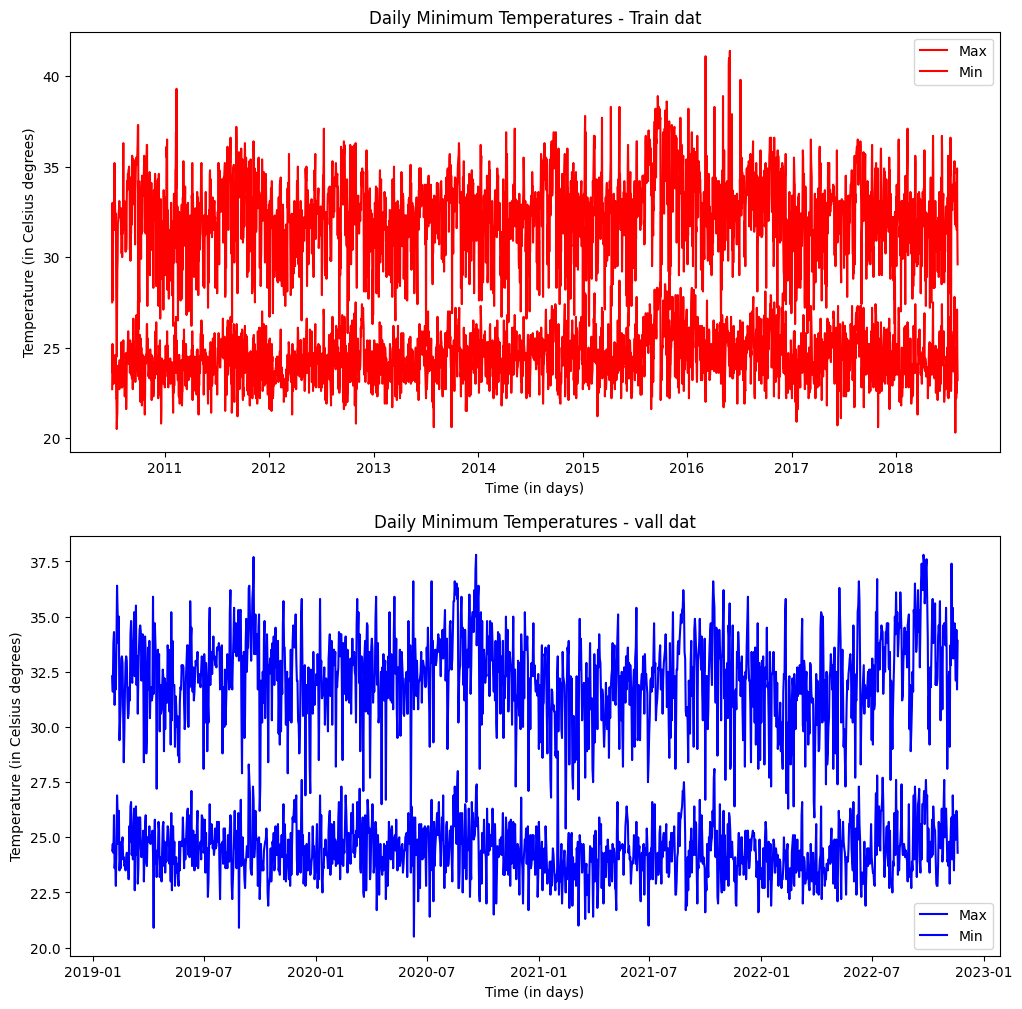

In [23]:

y_real_train= scaler.inverse_transform(Y_train.reshape(-1,2))
y_real_train_T = pd.to_datetime(t_train)

y_real_vall= scaler.inverse_transform(y_vall.reshape(-1,2))

y_real_vall_T = pd.to_datetime(t_vall)

fig=plt.figure(figsize=(12, 12))

ax1=plt.subplot(2,1,1)
plt.plot(y_real_train_T,y_real_train, color='red', label=['Max','Min'])
ax1.set_title('Daily Minimum Temperatures - Train dat')
ax1.set_xlabel('Time (in days)')
ax1.set_ylabel('Temperature (in Celsius degrees)')
ax1.legend()

ax2=plt.subplot(2,1,2)
plt.plot(y_real_vall_T,y_real_vall, color='blue', label=['Max','Min'])
ax2.set_title('Daily Minimum Temperatures - vall dat')
ax2.set_xlabel('Time (in days)')
ax2.set_ylabel('Temperature (in Celsius degrees)')
ax2.legend()

plt.show()

### deep learning model 

In [24]:
# Set the random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [25]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform
from tensorflow.keras.layers import GRU, Dense

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(8, kernel_size=3, strides=1, activation='relu',input_shape=(windows_size,2), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(MaxPooling1D(2))
    model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X_train)
model=dense_layers(features, n_outputs = 2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 178, 8)            56        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 89, 8)            0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 64)                14208     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                        

2023-06-27 15:13:18.813627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
#plotting the model architechture
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### Callbacks

In [27]:

EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=30, verbose=1, mode="min", restore_best_weights=True,)

checkpoint_filepath =f'models/{model_name}_{windows_size}_temp'

csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)

print("Training model :", checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 3, min_lr=1e-14,verbose=1)
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))


Training model : models/CNN_LSTM_180_temp


#### metrics

In [28]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

In [29]:
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
optimizer1 = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
#optimizer1 = tf.keras.optimizers.RMSprop()

model.compile(loss=tf.keras.losses.mse, optimizer=optimizer1,metrics=[NRMSE])
history=model.fit( x=X_train, y=Y_train, shuffle=True, validation_data=(X_vall,y_vall), epochs=200, batch_size=255,callbacks=[EarlyStopping,model_checkpoint_callback,reduceLr])

Epoch 1/200
11/12 [==========================>...] - ETA: 0s - loss: 0.1863 - NRMSE: 0.5892
Epoch 1: val_loss improved from inf to 0.05742, saving model to models/CNN_LSTM_180_temp


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


12/12 [==============================] - 4s 235ms/step - loss: 0.1806 - NRMSE: 0.6004 - val_loss: 0.0574 - val_NRMSE: 0.7572 - lr: 0.0100
Epoch 2/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0501 - NRMSE: 0.7766
Epoch 2: val_loss improved from 0.05742 to 0.01462, saving model to models/CNN_LSTM_180_temp


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


12/12 [==============================] - 2s 220ms/step - loss: 0.0499 - NRMSE: 0.7775 - val_loss: 0.0146 - val_NRMSE: 0.8780 - lr: 0.0100
Epoch 3/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0314 - NRMSE: 0.8231
Epoch 3: val_loss did not improve from 0.01462
12/12 [==============================] - 1s 44ms/step - loss: 0.0310 - NRMSE: 0.8250 - val_loss: 0.0176 - val_NRMSE: 0.8660 - lr: 0.0100
Epoch 4/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0256 - NRMSE: 0.8402
Epoch 4: val_loss improved from 0.01462 to 0.01448, saving model to models/CNN_LSTM_180_temp


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


12/12 [==============================] - 2s 202ms/step - loss: 0.0256 - NRMSE: 0.8400 - val_loss: 0.0145 - val_NRMSE: 0.8783 - lr: 0.0100
Epoch 5/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0220 - NRMSE: 0.8517
Epoch 5: val_loss improved from 0.01448 to 0.01289, saving model to models/CNN_LSTM_180_temp


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


12/12 [==============================] - 3s 226ms/step - loss: 0.0219 - NRMSE: 0.8523 - val_loss: 0.0129 - val_NRMSE: 0.8851 - lr: 0.0100
Epoch 6/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0209 - NRMSE: 0.8555
Epoch 6: val_loss did not improve from 0.01289
12/12 [==============================] - 1s 44ms/step - loss: 0.0210 - NRMSE: 0.8552 - val_loss: 0.0135 - val_NRMSE: 0.8821 - lr: 0.0100
Epoch 7/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0194 - NRMSE: 0.8608
Epoch 7: val_loss did not improve from 0.01289
12/12 [==============================] - 1s 45ms/step - loss: 0.0195 - NRMSE: 0.8603 - val_loss: 0.0132 - val_NRMSE: 0.8839 - lr: 0.0100
Epoch 8/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0185 - NRMSE: 0.8643
Epoch 8: val_loss did not improve from 0.01289

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
12/12 [==============================] - 1s 45ms/step - loss: 0.0185 - NRMSE: 0.8640 - val_los

INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
12/12 [==============================] - 2s 200ms/step - loss: 0.0175 - NRMSE: 0.8680 - val_loss: 0.0128 - val_NRMSE: 0.8854 - lr: 0.0020
Epoch 12/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0172 - NRMSE: 0.8688
Epoch 12: val_loss improved from 0.01284 to 0.01275, saving model to models/CNN_LSTM_180_temp


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


12/12 [==============================] - 3s 227ms/step - loss: 0.0173 - NRMSE: 0.8686 - val_loss: 0.0127 - val_NRMSE: 0.8859 - lr: 4.0000e-04
Epoch 13/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0180 - NRMSE: 0.8660
Epoch 13: val_loss improved from 0.01275 to 0.01273, saving model to models/CNN_LSTM_180_temp


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


12/12 [==============================] - 2s 201ms/step - loss: 0.0179 - NRMSE: 0.8667 - val_loss: 0.0127 - val_NRMSE: 0.8860 - lr: 4.0000e-04
Epoch 14/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0177 - NRMSE: 0.8673
Epoch 14: val_loss improved from 0.01273 to 0.01273, saving model to models/CNN_LSTM_180_temp


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


INFO:tensorflow:Assets written to: models/CNN_LSTM_180_temp/assets


12/12 [==============================] - 3s 248ms/step - loss: 0.0176 - NRMSE: 0.8678 - val_loss: 0.0127 - val_NRMSE: 0.8860 - lr: 4.0000e-04
Epoch 15/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0181 - NRMSE: 0.8655
Epoch 15: val_loss did not improve from 0.01273

Epoch 15: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.
12/12 [==============================] - 1s 45ms/step - loss: 0.0181 - NRMSE: 0.8657 - val_loss: 0.0127 - val_NRMSE: 0.8859 - lr: 4.0000e-04
Epoch 16/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0174 - NRMSE: 0.8680
Epoch 16: val_loss did not improve from 0.01273
12/12 [==============================] - 1s 50ms/step - loss: 0.0174 - NRMSE: 0.8683 - val_loss: 0.0127 - val_NRMSE: 0.8859 - lr: 8.0000e-05
Epoch 17/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0175 - NRMSE: 0.8678
Epoch 17: val_loss did not improve from 0.01273
12/12 [==============================] - 1s 49ms/step - loss: 0.0175 - NRMS

11/12 [==========================>...] - ETA: 0s - loss: 0.0171 - NRMSE: 0.8693
Epoch 41: val_loss did not improve from 0.01273
12/12 [==============================] - 1s 45ms/step - loss: 0.0173 - NRMSE: 0.8683 - val_loss: 0.0128 - val_NRMSE: 0.8858 - lr: 2.0480e-10
Epoch 42/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0180 - NRMSE: 0.8658
Epoch 42: val_loss did not improve from 0.01273

Epoch 42: ReduceLROnPlateau reducing learning rate to 4.095999650566285e-11.
12/12 [==============================] - 1s 44ms/step - loss: 0.0180 - NRMSE: 0.8657 - val_loss: 0.0128 - val_NRMSE: 0.8858 - lr: 2.0480e-10
Epoch 43/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0183 - NRMSE: 0.8648
Epoch 43: val_loss did not improve from 0.01273
12/12 [==============================] - 1s 45ms/step - loss: 0.0182 - NRMSE: 0.8651 - val_loss: 0.0128 - val_NRMSE: 0.8858 - lr: 4.0960e-11
Epoch 44/200
11/12 [==========================>...] - ETA: 0s - loss: 0.0176 - NRMSE: 0.8

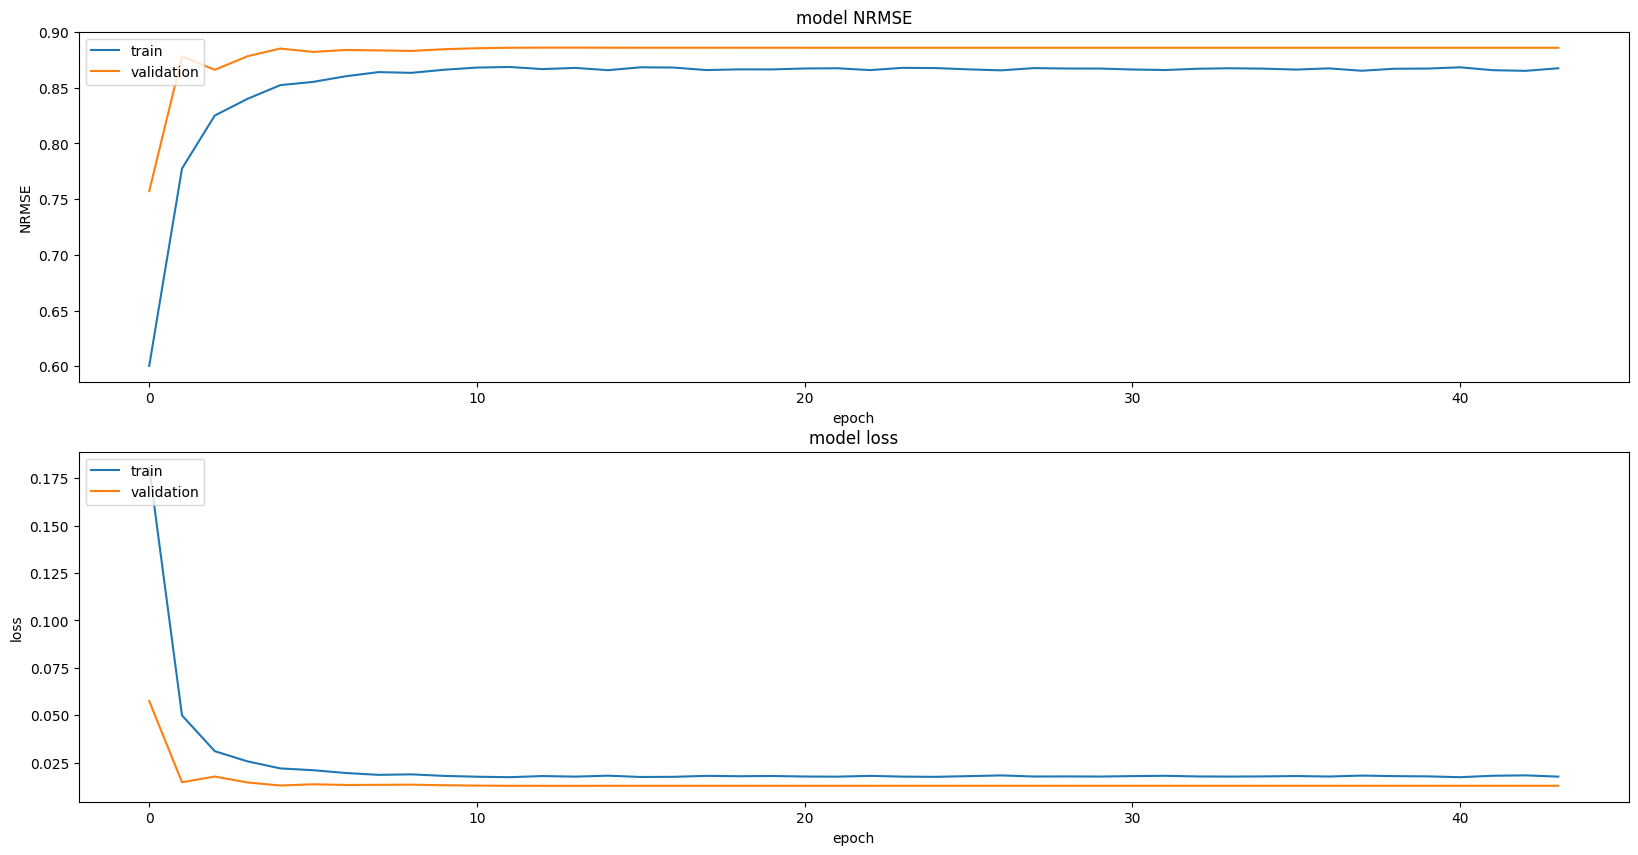

In [30]:
plt.figure(1,figsize=(20,10))  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['NRMSE']) 
plt.plot(history.history['val_NRMSE'])  
plt.title('model NRMSE')  
plt.ylabel('NRMSE')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left') 
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])   
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  

In [31]:
checkpoint_filepath

'models/CNN_LSTM_180_temp'

In [32]:
from tensorflow import keras
model=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [33]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )


y_pred=scaler.inverse_transform(model.predict(X_vall))
r2_score= R2(y_real_vall, y_pred )
print('NN R2:', r2_score)

44/44 [==============================] - 0s 5ms/step
NN R2: 0.8582405691407738


In [34]:
# Evaluate the stacked model
mse = mean_squared_error(y_real_vall,y_pred)
print('NN MSE:', mse)

NN MSE: 2.5996011084078345


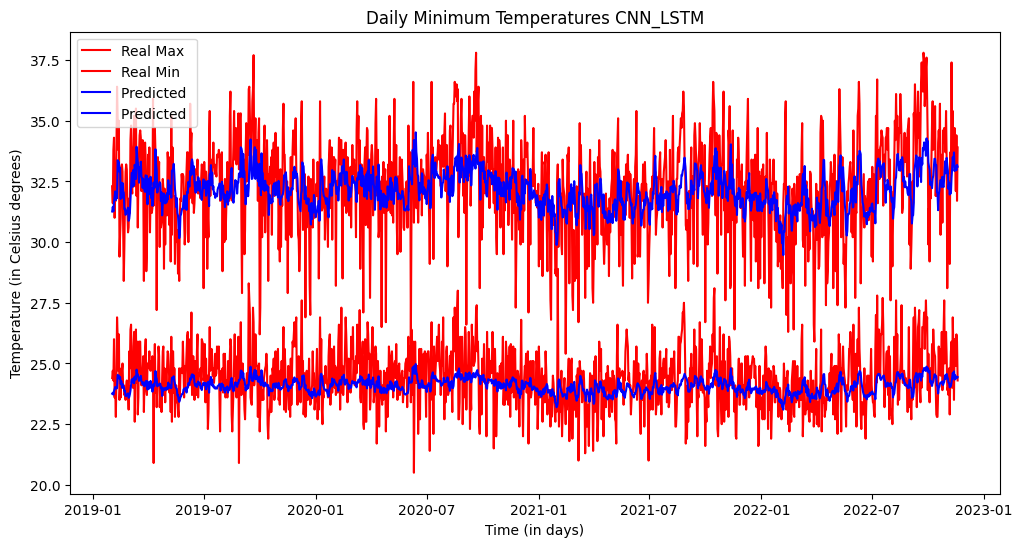

In [35]:
# Plot the real and predicted temperature values
plt.figure(figsize=(12, 6))
plt.plot(y_real_vall_T, y_real_vall, color='red', label=['Real Max','Real Min'])
plt.plot(y_real_vall_T,y_pred, color='blue', label='Predicted ')
plt.title(f'Daily Minimum Temperatures {model_name}')
plt.xlabel('Time (in days)')
plt.ylabel('Temperature (in Celsius degrees)')
plt.legend()
plt.show()

### DNN

In [36]:
model_name= "MLP"
# Camada de entrada
input_data = Input(shape=(windows_size,2))

dense_output = Flatten()(input_data)

dense_output = Dense(128, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

dense_output = Dense(128, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

#dense_output = Dense(10, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

# Camada de saída
output = Dense(2, activation='linear')(dense_output)


model_DNN = Model(inputs=input_data, outputs=output)
model_DNN.summary()


#plotting the model architechture
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(model_DNN, show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 2)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 360)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               46208     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 62,978
Trainable params: 62,978
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install 

In [37]:

EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=30, verbose=1, mode="min", restore_best_weights=True,)
checkpoint_filepath =f'models/{model_name}_{windows_size}_temp'

csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)

print("Training model :", checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 3, min_lr=1e-14,verbose=1)
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

Training model : models/MLP_180_temp


In [38]:
from tensorflow.keras import backend as K

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
optimizer1 = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
#optimizer1 = tf.keras.optimizers.RMSprop()

In [39]:
model_DNN.compile(loss=tf.keras.losses.mse, optimizer=optimizer1,metrics=[NRMSE])
history=model_DNN.fit( x=X_train, y=Y_train, shuffle=True, validation_data=(X_vall,y_vall), epochs=200, batch_size=255,callbacks=[EarlyStopping,model_checkpoint_callback,reduceLr])

Epoch 1/200
 1/12 [=>............................] - ETA: 2s - loss: 0.4085 - NRMSE: 0.3609
Epoch 1: val_loss improved from inf to 0.03039, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 1s 35ms/step - loss: 0.1262 - NRMSE: 0.6701 - val_loss: 0.0304 - val_NRMSE: 0.8228 - lr: 0.0100
Epoch 2/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0351 - NRMSE: 0.8126
Epoch 2: val_loss improved from 0.03039 to 0.02492, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0331 - NRMSE: 0.8194 - val_loss: 0.0249 - val_NRMSE: 0.8399 - lr: 0.0100
Epoch 3/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0311 - NRMSE: 0.8237
Epoch 3: val_loss improved from 0.02492 to 0.01441, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 29ms/step - loss: 0.0205 - NRMSE: 0.8583 - val_loss: 0.0144 - val_NRMSE: 0.8783 - lr: 0.0100
Epoch 4/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0160 - NRMSE: 0.8734
Epoch 4: val_loss improved from 0.01441 to 0.01416, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0172 - NRMSE: 0.8685 - val_loss: 0.0142 - val_NRMSE: 0.8802 - lr: 0.0100
Epoch 5/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0167 - NRMSE: 0.8708
Epoch 5: val_loss improved from 0.01416 to 0.01370, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 29ms/step - loss: 0.0163 - NRMSE: 0.8726 - val_loss: 0.0137 - val_NRMSE: 0.8814 - lr: 0.0100
Epoch 6/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0186 - NRMSE: 0.8635
Epoch 6: val_loss improved from 0.01370 to 0.01341, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 31ms/step - loss: 0.0159 - NRMSE: 0.8739 - val_loss: 0.0134 - val_NRMSE: 0.8830 - lr: 0.0100
Epoch 7/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0160 - NRMSE: 0.8737
Epoch 7: val_loss improved from 0.01341 to 0.01340, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 29ms/step - loss: 0.0156 - NRMSE: 0.8751 - val_loss: 0.0134 - val_NRMSE: 0.8834 - lr: 0.0100
Epoch 8/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0176 - NRMSE: 0.8675
Epoch 8: val_loss improved from 0.01340 to 0.01319, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 30ms/step - loss: 0.0153 - NRMSE: 0.8762 - val_loss: 0.0132 - val_NRMSE: 0.8840 - lr: 0.0100
Epoch 9/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0143 - NRMSE: 0.8803
Epoch 9: val_loss improved from 0.01319 to 0.01303, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 30ms/step - loss: 0.0151 - NRMSE: 0.8771 - val_loss: 0.0130 - val_NRMSE: 0.8850 - lr: 0.0100
Epoch 10/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0150 - NRMSE: 0.8773
Epoch 10: val_loss improved from 0.01303 to 0.01295, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0149 - NRMSE: 0.8778 - val_loss: 0.0129 - val_NRMSE: 0.8853 - lr: 0.0100
Epoch 11/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0159 - NRMSE: 0.8739
Epoch 11: val_loss improved from 0.01295 to 0.01289, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0148 - NRMSE: 0.8790 - val_loss: 0.0129 - val_NRMSE: 0.8857 - lr: 0.0100
Epoch 12/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0155 - NRMSE: 0.8756
Epoch 12: val_loss improved from 0.01289 to 0.01284, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 1s 49ms/step - loss: 0.0146 - NRMSE: 0.8791 - val_loss: 0.0128 - val_NRMSE: 0.8858 - lr: 0.0100
Epoch 13/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0160 - NRMSE: 0.8736
Epoch 13: val_loss improved from 0.01284 to 0.01278, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0145 - NRMSE: 0.8798 - val_loss: 0.0128 - val_NRMSE: 0.8863 - lr: 0.0100
Epoch 14/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0162 - NRMSE: 0.8729
Epoch 14: val_loss improved from 0.01278 to 0.01271, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0145 - NRMSE: 0.8801 - val_loss: 0.0127 - val_NRMSE: 0.8866 - lr: 0.0100
Epoch 15/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0144 - NRMSE: 0.8799
Epoch 15: val_loss improved from 0.01271 to 0.01264, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 29ms/step - loss: 0.0143 - NRMSE: 0.8803 - val_loss: 0.0126 - val_NRMSE: 0.8869 - lr: 0.0100
Epoch 16/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0146 - NRMSE: 0.8792
Epoch 16: val_loss did not improve from 0.01264
12/12 [==============================] - 0s 3ms/step - loss: 0.0143 - NRMSE: 0.8805 - val_loss: 0.0127 - val_NRMSE: 0.8869 - lr: 0.0100
Epoch 17/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0144 - NRMSE: 0.8798
Epoch 17: val_loss improved from 0.01264 to 0.01261, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0142 - NRMSE: 0.8810 - val_loss: 0.0126 - val_NRMSE: 0.8870 - lr: 0.0100
Epoch 18/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0160 - NRMSE: 0.8733
Epoch 18: val_loss improved from 0.01261 to 0.01253, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0141 - NRMSE: 0.8812 - val_loss: 0.0125 - val_NRMSE: 0.8875 - lr: 0.0100
Epoch 19/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0144 - NRMSE: 0.8798
Epoch 19: val_loss improved from 0.01253 to 0.01249, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0141 - NRMSE: 0.8814 - val_loss: 0.0125 - val_NRMSE: 0.8877 - lr: 0.0100
Epoch 20/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0135 - NRMSE: 0.8839
Epoch 20: val_loss improved from 0.01249 to 0.01248, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0140 - NRMSE: 0.8821 - val_loss: 0.0125 - val_NRMSE: 0.8878 - lr: 0.0100
Epoch 21/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0139 - NRMSE: 0.8822
Epoch 21: val_loss improved from 0.01248 to 0.01242, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 29ms/step - loss: 0.0139 - NRMSE: 0.8821 - val_loss: 0.0124 - val_NRMSE: 0.8880 - lr: 0.0100
Epoch 22/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0140 - NRMSE: 0.8818
Epoch 22: val_loss did not improve from 0.01242
12/12 [==============================] - 0s 4ms/step - loss: 0.0138 - NRMSE: 0.8823 - val_loss: 0.0125 - val_NRMSE: 0.8877 - lr: 0.0100
Epoch 23/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0150 - NRMSE: 0.8777
Epoch 23: val_loss improved from 0.01242 to 0.01237, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0139 - NRMSE: 0.8821 - val_loss: 0.0124 - val_NRMSE: 0.8883 - lr: 0.0100
Epoch 24/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0147 - NRMSE: 0.8787
Epoch 24: val_loss did not improve from 0.01237

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
12/12 [==============================] - 0s 4ms/step - loss: 0.0137 - NRMSE: 0.8830 - val_loss: 0.0124 - val_NRMSE: 0.8883 - lr: 0.0100
Epoch 25/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0127 - NRMSE: 0.8874
Epoch 25: val_loss did not improve from 0.01237
12/12 [==============================] - 0s 4ms/step - loss: 0.0138 - NRMSE: 0.8825 - val_loss: 0.0124 - val_NRMSE: 0.8884 - lr: 0.0020
Epoch 26/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0142 - NRMSE: 0.8809
Epoch 26: val_loss improved from 0.01237 to 0.01234, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 29ms/step - loss: 0.0137 - NRMSE: 0.8833 - val_loss: 0.0123 - val_NRMSE: 0.8884 - lr: 0.0020
Epoch 27/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0156 - NRMSE: 0.8751
Epoch 27: val_loss improved from 0.01234 to 0.01232, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 28ms/step - loss: 0.0137 - NRMSE: 0.8834 - val_loss: 0.0123 - val_NRMSE: 0.8885 - lr: 0.0020
Epoch 28/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0117 - NRMSE: 0.8917
Epoch 28: val_loss improved from 0.01232 to 0.01231, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 30ms/step - loss: 0.0136 - NRMSE: 0.8834 - val_loss: 0.0123 - val_NRMSE: 0.8886 - lr: 0.0020
Epoch 29/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0142 - NRMSE: 0.8807
Epoch 29: val_loss improved from 0.01231 to 0.01231, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 29ms/step - loss: 0.0136 - NRMSE: 0.8833 - val_loss: 0.0123 - val_NRMSE: 0.8886 - lr: 0.0020
Epoch 30/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0131 - NRMSE: 0.8854
Epoch 30: val_loss improved from 0.01231 to 0.01231, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
12/12 [==============================] - 1s 54ms/step - loss: 0.0136 - NRMSE: 0.8833 - val_loss: 0.0123 - val_NRMSE: 0.8886 - lr: 0.0020
Epoch 31/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0140 - NRMSE: 0.8817
Epoch 31: val_loss improved from 0.01231 to 0.01230, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 32ms/step - loss: 0.0136 - NRMSE: 0.8833 - val_loss: 0.0123 - val_NRMSE: 0.8886 - lr: 4.0000e-04
Epoch 32/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0136 - NRMSE: 0.8833
Epoch 32: val_loss improved from 0.01230 to 0.01230, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 32ms/step - loss: 0.0136 - NRMSE: 0.8835 - val_loss: 0.0123 - val_NRMSE: 0.8886 - lr: 4.0000e-04
Epoch 33/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0141 - NRMSE: 0.8812
Epoch 33: val_loss improved from 0.01230 to 0.01230, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets



Epoch 33: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.
12/12 [==============================] - 0s 33ms/step - loss: 0.0136 - NRMSE: 0.8835 - val_loss: 0.0123 - val_NRMSE: 0.8886 - lr: 4.0000e-04
Epoch 34/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0127 - NRMSE: 0.8873
Epoch 34: val_loss improved from 0.01230 to 0.01230, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 33ms/step - loss: 0.0136 - NRMSE: 0.8833 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 8.0000e-05
Epoch 35/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0122 - NRMSE: 0.8895
Epoch 35: val_loss improved from 0.01230 to 0.01229, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 33ms/step - loss: 0.0136 - NRMSE: 0.8834 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 8.0000e-05
Epoch 36/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0131 - NRMSE: 0.8856
Epoch 36: val_loss improved from 0.01229 to 0.01229, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets



Epoch 36: ReduceLROnPlateau reducing learning rate to 1.599999814061448e-05.
12/12 [==============================] - 0s 31ms/step - loss: 0.0136 - NRMSE: 0.8832 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 8.0000e-05
Epoch 37/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0122 - NRMSE: 0.8897
Epoch 37: val_loss improved from 0.01229 to 0.01229, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 32ms/step - loss: 0.0136 - NRMSE: 0.8835 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 1.6000e-05
Epoch 38/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0122 - NRMSE: 0.8894
Epoch 38: val_loss improved from 0.01229 to 0.01229, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


12/12 [==============================] - 0s 32ms/step - loss: 0.0136 - NRMSE: 0.8833 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 1.6000e-05
Epoch 39/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0142 - NRMSE: 0.8807
Epoch 39: val_loss improved from 0.01229 to 0.01229, saving model to models/MLP_180_temp


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets


INFO:tensorflow:Assets written to: models/MLP_180_temp/assets



Epoch 39: ReduceLROnPlateau reducing learning rate to 3.199999628122896e-06.
12/12 [==============================] - 0s 32ms/step - loss: 0.0136 - NRMSE: 0.8837 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 1.6000e-05
Epoch 40/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0122 - NRMSE: 0.8895
Epoch 40: val_loss did not improve from 0.01229
12/12 [==============================] - 0s 4ms/step - loss: 0.0136 - NRMSE: 0.8836 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 3.2000e-06
Epoch 41/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0141 - NRMSE: 0.8812
Epoch 41: val_loss did not improve from 0.01229
12/12 [==============================] - 0s 4ms/step - loss: 0.0136 - NRMSE: 0.8832 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 3.2000e-06
Epoch 42/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0133 - NRMSE: 0.8847
Epoch 42: val_loss did not improve from 0.01229

Epoch 42: ReduceLROnPlateau reducing learning rate to 6.399999165296323e-07.


 1/12 [=>............................] - ETA: 0s - loss: 0.0139 - NRMSE: 0.8820
Epoch 66: val_loss did not improve from 0.01229

Epoch 66: ReduceLROnPlateau reducing learning rate to 1.6383998324709382e-12.
12/12 [==============================] - 0s 4ms/step - loss: 0.0136 - NRMSE: 0.8833 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 8.1920e-12
Epoch 67/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0136 - NRMSE: 0.8835
Epoch 67: val_loss did not improve from 0.01229
12/12 [==============================] - 0s 4ms/step - loss: 0.0136 - NRMSE: 0.8832 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 1.6384e-12
Epoch 68/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0132 - NRMSE: 0.8851
Epoch 68: val_loss did not improve from 0.01229
12/12 [==============================] - 0s 4ms/step - loss: 0.0136 - NRMSE: 0.8836 - val_loss: 0.0123 - val_NRMSE: 0.8887 - lr: 1.6384e-12
Epoch 69/200
 1/12 [=>............................] - ETA: 0s - loss: 0.0136 - NRMSE: 0.883

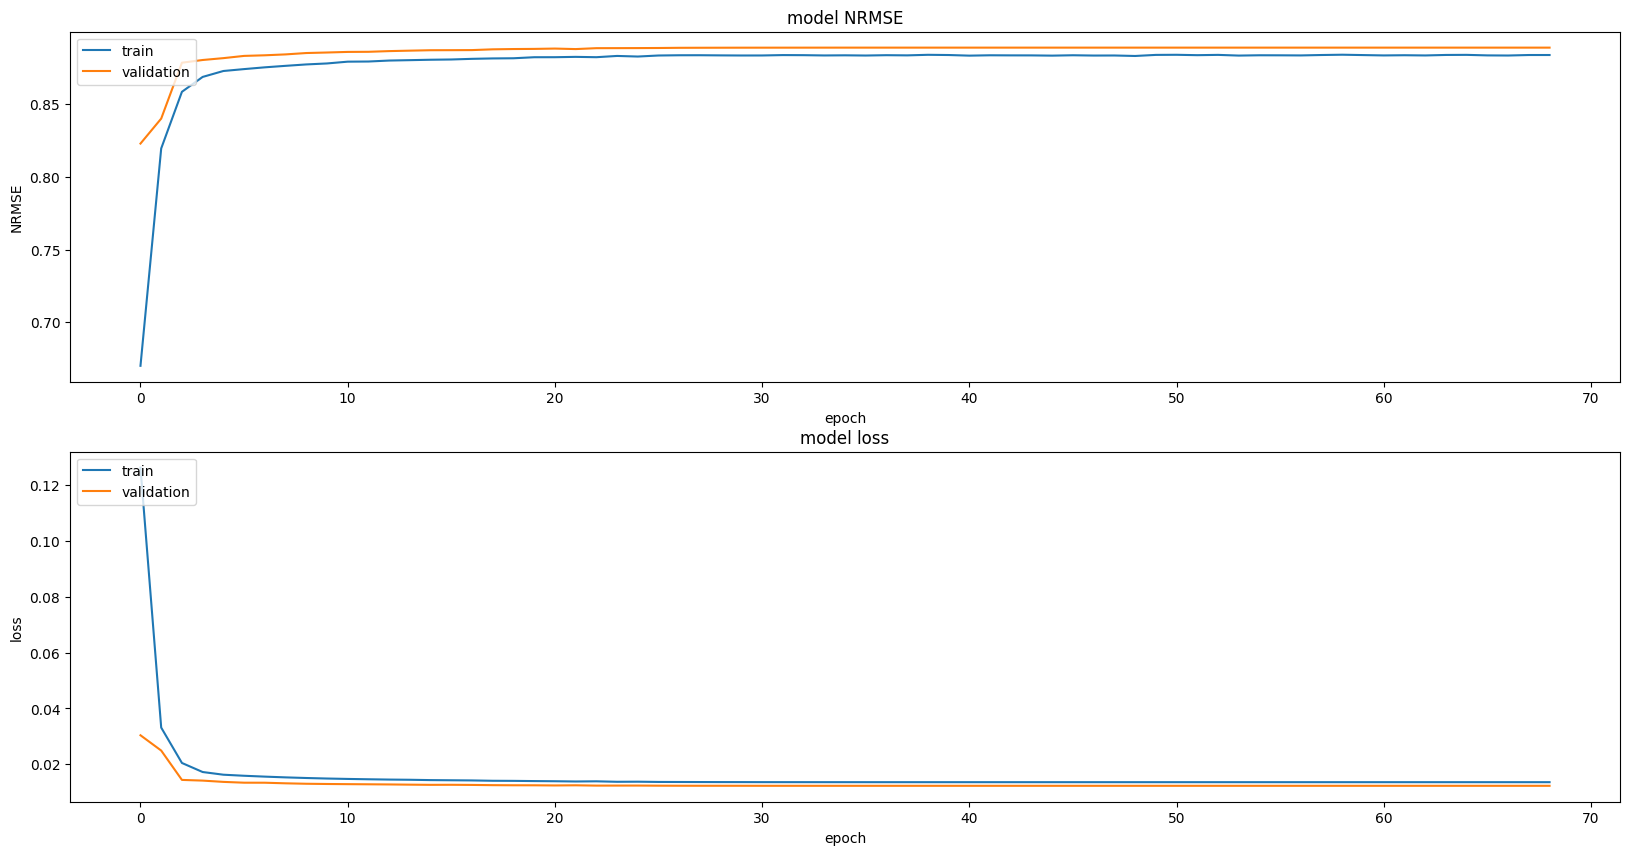

In [40]:
plt.figure(1,figsize=(20,10))  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['NRMSE']) 
plt.plot(history.history['val_NRMSE'])  
plt.title('model NRMSE')  
plt.ylabel('NRMSE')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left') 
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])   
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  

In [41]:
checkpoint_filepath

'models/MLP_180_temp'

In [42]:
from tensorflow import keras
model_DNN=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})
# Evaluate the stacked model

y_pred_DNN=scaler.inverse_transform(model_DNN.predict(X_vall))
r2_score= R2(y_real_vall, y_pred_DNN )
print('NN R2:', r2_score)
mse = mean_squared_error(y_real_vall,y_pred)
print('NN MSE:', mse)

44/44 [==============================] - 0s 567us/step
NN R2: 0.860566535024779
NN MSE: 2.5996011084078345


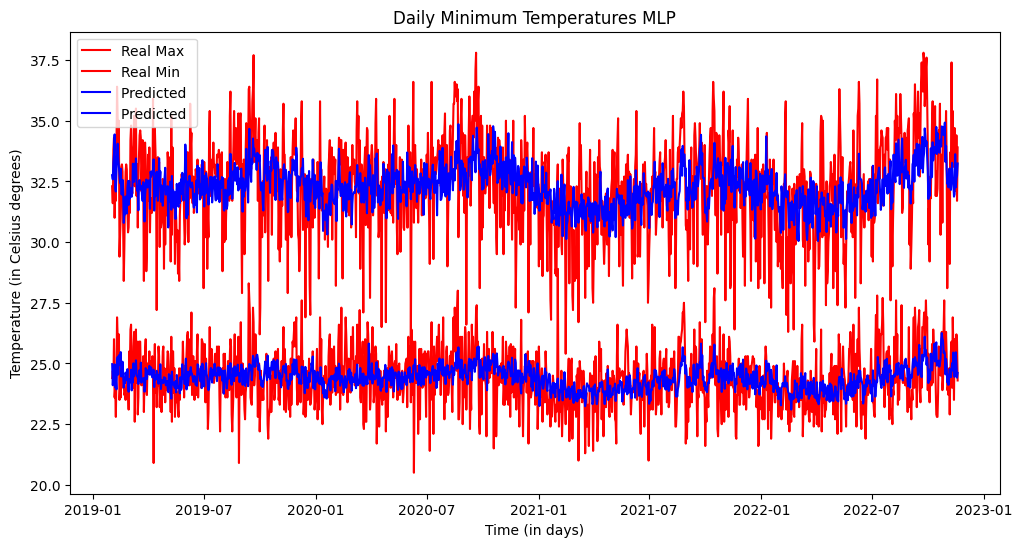

In [43]:

# Plot the real and predicted temperature values
plt.figure(figsize=(12, 6))
plt.plot(y_real_vall_T, y_real_vall, color='red', label=['Real Max','Real Min'])
plt.plot(y_real_vall_T,y_pred_DNN, color='blue', label='Predicted ')
plt.title(f'Daily Minimum Temperatures {model_name}')
plt.xlabel('Time (in days)')
plt.ylabel('Temperature (in Celsius degrees)')
plt.legend()
plt.show()

### Generating the predicted values for the next Steps  periods


In [44]:
last_window_CNN = np.array(data.tail(windows_size)[['Temp max','Temp min']]).reshape(windows_size,2)
last_window_DNN=last_window_CNN.copy()

predicted_values_CNN = []
predicted_values_DNN = []
temp=real_temp.index.values[-1:]

In [45]:
for i in range(Steps_ahead+25):
    ### NN 
    last_window_scaler_CNN= scaler.transform(last_window_CNN.reshape(-1,2))
    
    y_pred_CNN=model.predict(last_window_scaler_CNN.reshape(1,-1,2))
    
    predicted_values_CNN.append(scaler.inverse_transform(y_pred_CNN)[0])
    
    last_window_CNN = np.append(last_window_CNN[1:,:], predicted_values_CNN[-1].reshape(-1,2),axis=0)
    
    ################################
    last_window_scaler_DNN= scaler.transform(last_window_DNN.reshape(-1,2))
    
    y_pred_DNN=model_DNN.predict(last_window_scaler_DNN.reshape(1,-1,2))
    
    predicted_values_DNN.append(scaler.inverse_transform(y_pred_DNN)[0])
    
    last_window_DNN = np.append(last_window_DNN[1:,:], predicted_values_DNN[-1].reshape(-1,2),axis=0)
    
    ################################
    
    temp=np.append(temp,temp[-1]+np.timedelta64(1,'D'))

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


In [46]:
predicted_values_CNN=np.vstack(predicted_values_CNN)
temp=temp[1:]

In [47]:
predicted_values_CNN.shape

(205, 2)

In [48]:
temp[-1]

numpy.datetime64('2024-06-27T00:00:00.000000000')

Text(0, 0.5, 'Temperature (Celsius)')

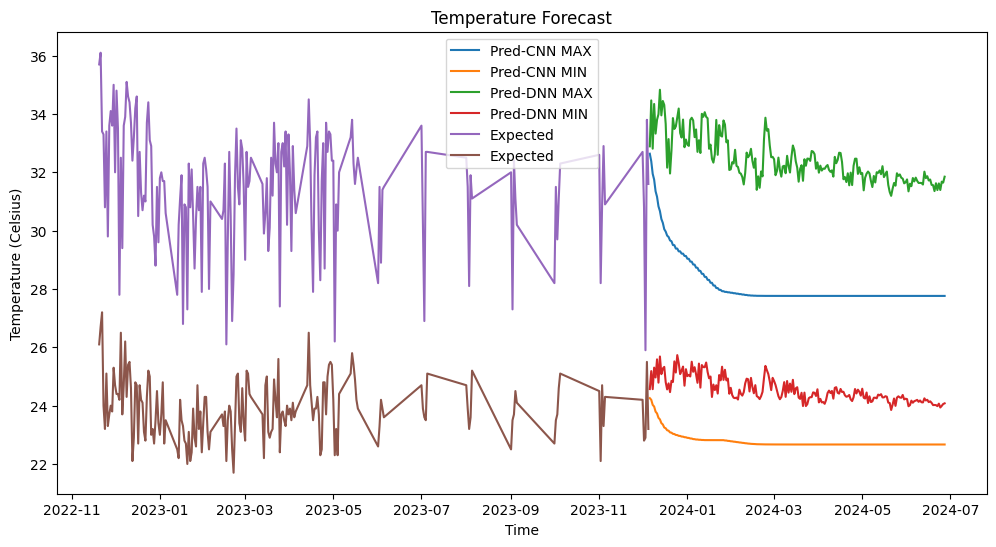

In [49]:
real_temp.index = pd.to_datetime(real_temp.index)
#predicted_values_NN= scaler.inverse_transform(np.array(predicted_values_NN).reshape(-1,1))
#predicted_values_xgb= scaler.inverse_transform(np.array(predicted_values_xgb).reshape(-1,1))


plt.figure(figsize=(12, 6))
plt.plot(temp, predicted_values_CNN, label=['Pred-CNN MAX','Pred-CNN MIN'])
plt.plot(temp, predicted_values_DNN, label=['Pred-DNN MAX','Pred-DNN MIN'])

plt.plot(real_temp.index, real_temp, label='Expected')
plt.legend()
plt.title('Temperature Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature (Celsius)')



In [50]:
temp[-2:]

array(['2024-06-26T00:00:00.000000000', '2024-06-27T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [51]:
predicted_values_DNN[-2:]

[array([31.647423, 24.055962], dtype=float32),
 array([31.849403, 24.0785  ], dtype=float32)]